In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# https://docs.pytorch.org/tutorials/beginner/basics/intro.html

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [6]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [10]:
batch_size = 16 # epoch 1000의 경우 16으로 진행

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 1, 28, 28])
Shape of y: torch.Size([16]) torch.int64


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU() ,
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

Using cuda device


In [12]:
model = NeuralNetwork().to(device)

print(model)

loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [13]:
def train(dataloader, model, loss_fun, optimizer):
    size = len(dataloader.dataset)
    model.train()               # 학습 모드
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fun(pred, y)

        loss.backward()         # 역전파
        optimizer.step()        # 모델의 파라미터를 업데이트
        optimizer.zero_grad()   # gradient 초기화, 각 배치마다 gradient를 새로 계산해야 함.

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [14]:
def test(dataloader, model, loss_fun):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()        # 추론 모드
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fun(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 맞힌 개수를 전부 더함
    test_loss /= num_batches    # 평균 손실
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
def train_and_save(dataloader, model, loss_fun, optimizer, train_loss_memo : list):
    index = len(train_loss_memo)
    train_loss_memo.append(list())
    size = len(dataloader.dataset)
    model.train()               # 학습 모드
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fun(pred, y)

        loss.backward()         # 역전파
        optimizer.step()        # 모델의 파라미터를 업데이트
        optimizer.zero_grad()   # gradient 초기화, 각 배치마다 gradient를 새로 계산해야 함.

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_loss_memo[index].append(loss_fun(pred, y).item())
    train_loss_memo[index].append(loss_fun(pred, y).item())

In [16]:
def test_and_save(dataloader, model, loss_fun, test_memo : list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()        # 추론 모드
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fun(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 맞힌 개수를 전부 더함
    test_loss /= num_batches    # 평균 손실
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    test_memo.append({'Avg_loss': test_loss, 'Accuracy': correct})

In [ ]:
epochs = 5 # 1 epoch = “훈련 데이터 전체를 한 번 다 사용해서 학습한 것”.

for t in range(epochs):
    print(f'Epoch {t+1}\n---------------------------------')
    train(train_dataloader, model, loss_fun, optimizer)
    test(test_dataloader, model, loss_fun)
print('Done')

In [ ]:
epochs = 5000 # 1 epoch = “훈련 데이터 전체를 한 번 다 사용해서 학습한 것”.

#train_loss_memo = [[] for i in range(epochs)]
train_memo = []
test_memo = []

# 학습할 때 모델 초기화를 안하는거 주의

for t in range(epochs):
    print(f'Epoch {t+1}\n---------------------------------')
    #train_and_save(train_dataloader, model, loss_fun, optimizer, train_loss_memo[t])
    train(train_dataloader, model, loss_fun, optimizer)
    print('train: ', end='')
    test_and_save(train_dataloader, model, loss_fun, train_memo)
    print('test: ', end='')
    test_and_save(test_dataloader, model, loss_fun, test_memo)
print('Done')

df1 = pd.DataFrame(train_memo)

df2 = pd.DataFrame(test_memo)

# CSV로 저장
df1.to_csv(f"train_memo_{epochs}.csv", index=False)

df2.to_csv(f"test_memo_{epochs}.csv", index=False)

Epoch 1
---------------------------------
loss: 2.319402  [   16/60000]
loss: 2.294139  [ 1616/60000]
loss: 2.273785  [ 3216/60000]
loss: 2.279857  [ 4816/60000]
loss: 2.234500  [ 6416/60000]
loss: 2.238428  [ 8016/60000]
loss: 2.208791  [ 9616/60000]
loss: 2.169446  [11216/60000]
loss: 2.191282  [12816/60000]
loss: 2.138879  [14416/60000]
loss: 2.153881  [16016/60000]
loss: 2.111592  [17616/60000]
loss: 2.086379  [19216/60000]
loss: 2.071771  [20816/60000]
loss: 2.056669  [22416/60000]
loss: 2.003089  [24016/60000]
loss: 1.979674  [25616/60000]
loss: 2.045178  [27216/60000]
loss: 1.907230  [28816/60000]
loss: 1.901773  [30416/60000]
loss: 1.813672  [32016/60000]
loss: 1.699304  [33616/60000]
loss: 1.638467  [35216/60000]
loss: 1.750376  [36816/60000]
loss: 1.795716  [38416/60000]
loss: 1.584955  [40016/60000]
loss: 1.570856  [41616/60000]
loss: 1.648428  [43216/60000]
loss: 1.386064  [44816/60000]
loss: 1.515726  [46416/60000]
loss: 1.535805  [48016/60000]
loss: 1.319636  [49616/60000

In [85]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [88]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [3]:
def plot_history(train_memo : list, test_memo : list, start : int = 0, end : int = 0):
    train_memo_loss = [m['Avg_loss'] for m in train_memo]
    train_memo_acc = [m['Accuracy'] for m in train_memo]

    test_memo_loss = [m['Avg_loss'] for m in test_memo]
    test_memo_acc = [m['Accuracy'] for m in test_memo]

    # Epoch 수
    start_end = range(start + 1, end + 1)

    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="red")
    ax1.plot(start_end, test_memo_loss[start:end], label="Test Loss", color="salmon")
    ax1.plot(start_end, train_memo_loss[start:end], label="Train Loss", color="darkblue")
    ax1.tick_params(axis='y', labelcolor="red")
    ax1.legend()

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy ( -- )", color="blue")
    ax2.plot(start_end, test_memo_acc[start:end], label="Test Accuracy", color="darkred", linestyle="--")
    ax2.plot(start_end, train_memo_acc[start:end], label="train Accuracy",  color="skyblue", linestyle="--")
    ax2.tick_params(axis='y', labelcolor="blue")
    ax2.legend()

    plt.title("Train_test History")
    fig.tight_layout()
    plt.show()


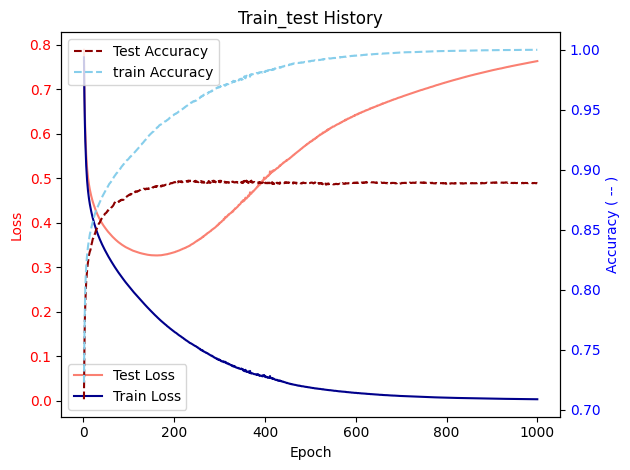

In [5]:
read_epochs = 1000 # 이걸 수정해서 불러올 파일 번호(당시 epochs 세팅값)에 해당하는 .csv파일을 불러옴

df1 = pd.read_csv(f"train_memo_{read_epochs}.csv")
df2 = pd.read_csv(f"test_memo_{read_epochs}.csv")

train_record = df1.to_dict(orient="records")
test_record = df2.to_dict(orient="records")

# range(start, end)범위로 그림
plot_history(train_memo=train_record, test_memo=test_record, start=0, end=len(train_record))